<a href="https://colab.research.google.com/github/aperrier004/MEWO_BARBOSA_PERRIER/blob/main/f1_loss_Mewo_BARBOSA_PERRIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors : Rémi BARBOSA & Alban PERRIER

# Mewo challenge

More info on the [challenge site](https://challengedata.ens.fr/professors/challenges/43/).

In [ ]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## Data reading

Requirements : train_X.csv, train_y.csv, pred_y.csv and mewo-labels.csv.

**WARNING**

If you want to run this notebook, please modify the PATH variable, here we use Google Drive, be carefule about the name of the files too.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/ENSC/3A/[B] Science des Données et Apprentissage/Apprentissage Automatique/Challenge mewo/'

x_data_init = pd.read_csv(PATH+'train_X.csv', index_col=0, sep=',')
y_data = pd.read_csv(PATH+'train_y.csv', index_col=0, sep=',')
x_test = pd.read_csv(PATH+'test_X.csv', index_col=0, sep=',')
df_labels = pd.read_csv(PATH+'mewo-labels.csv', index_col=0, sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data discovery

In [ ]:
x_data_init.head(n=10)

,acid-jazz,alternative-rock,americana,blaxpoitation,bluegrass,blues-rock,bossa-nova,breakbeat,chill-out,classic-ambient,classical,contemporary-classical,contemporary-folk,contemporary-jazz,contemporary-pop,contemporary-rnb,country-blues,country-folk,country-pop,country-rock,drones,drum-n-bass,dubstep,easy-listening,edm,electro,electro-rock,electronica,film-score,folk-rock,funk-rock,garage-rock,gospel,hard-rock,heavy-metal,hip-hop,house,indie-folk,indie-pop,indie-rock,...,genres-blues,genres-cocktail-music,genres-country,genres-disco,genres-electronic-music,genres-folk,genres-funk,genres-jazz,genres-latin,genres-orchestral,genres-pop,genres-reggae,genres-rnb,genres-rock,genres-traditional,genres-urban,genres-world,instruments-brass,instruments-drums,instruments-ensembles,instruments-ensembles-orchestral,instruments-keyboards,instruments-keyboards-electronic,instruments-others,instruments-percussions,instruments-percussions-mallet,instruments-strings-bowed-instruments,instruments-strings-plucked-strings,instruments-voices,instruments-voices-others,instruments-winds-others,instruments-woodwinds,mood-dark,mood-dramatic,mood-emotional,mood-love,mood-positive,mood-powerful,mood-tender,mood-tense
ChallengeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000023,0.006455,0.001339,0.000159,0.000045,0.000191,0.000087,0.014584,0.007135,0.010316,0.018971,0.023930,0.001575,0.007633,0.000264,0.000113,0.000028,0.000077,0.000089,0.000549,0.013441,0.000548,0.014392,0.000749,0.013649,0.025120,0.013824,0.320161,0.352349,0.000550,0.000223,0.000868,0.000026,0.002960,0.005464,0.003563,0.003888,0.000515,0.007536,0.047376,...,0.000364,0.001542,0.002267,0.000118,0.808447,0.001314,0.000536,0.001115,0.002490,0.710874,0.013682,0.000680,0.000471,0.050161,0.019057,0.002937,0.055488,0.520967,0.464302,0.041782,0.820145,0.140254,0.578243,0.007306,0.248259,0.551655,0.034324,0.140184,0.389768,0.363592,0.001656,0.039738,0.555135,0.866627,0.134449,0.009339,0.126845,0.393124,0.018300,0.641634
1,0.000069,0.056431,0.008977,0.000347,0.000536,0.001447,0.000093,0.047316,0.019435,0.005939,0.014535,0.006807,0.007178,0.090392,0.007400,0.002443,0.000128,0.000516,0.007802,0.018544,0.004532,0.000482,0.007520,0.005222,0.069116,0.011084,0.045196,0.266084,0.031419,0.002735,0.000852,0.008483,0.000664,0.007904,0.005491,0.021351,0.003329,0.002039,0.103383,0.161913,...,0.001739,0.006027,0.030122,0.000702,0.502521,0.011600,0.001056,0.000918,0.000651,0.182064,0.301615,0.000981,0.004211,0.207857,0.007870,0.021705,0.012325,0.042450,0.893891,0.642788,0.154561,0.208817,0.623371,0.005178,0.209401,0.071701,0.025399,0.826278,0.765673,0.798620,0.008765,0.008827,0.081464,0.835080,0.154436,0.021737,0.560761,0.239125,0.093487,0.131548
2,0.000039,0.017784,0.001067,0.000290,0.000021,0.001512,0.000033,0.109496,0.008511,0.009775,0.009322,0.031179,0.000364,0.007926,0.000307,0.000108,0.000062,0.000048,0.000079,0.000997,0.031112,0.000675,0.047684,0.000483,0.011581,0.044310,0.131119,0.493381,0.177750,0.000515,0.001371,0.009730,0.000021,0.071293,0.076663,0.016110,0.001789,0.000113,0.003392,0.080414,...,0.000936,0.001006,0.002173,0.000056,0.797744,0.000467,0.000629,0.000905,0.000468,0.415596,0.010691,0.000577,0.000467,0.222545,0.005932,0.007730,0.042258,0.256015,0.686607,0.053645,0.568332,0.056967,0.763496,0.006614,0.152986,0.188263,0.015507,0.164885,0.071654,0.090737,0.000635,0.009898,0.661375,0.906562,0.049434,0.005168,0.074466,0.455511,0.003603,0.713546
3,0.000047,0.004563,0.000289,0.000520,0.000013,0.000264,0.000026,0.265472,0.004216,0.002639,0.005890,0.012286,0.000184,0.013583,0.000547,0.000179,0.000009,0.000027,0.000054,0.000189,0.004560,0.001822,0.114699,0.000535,0.081488,0.054893,0.155983,0.647314,0.049505,0.000153,0.002081,0.003098,0.000016,0.012174,0.019197,0.013123,0.025651,0.000058,0.004323,0.033185,...,0.000172,0.001055,0.000907,0.000393,0.918250,0.000280,0.001197,0.000643,0.000802,0.304711,0.023456,0.000805,0.000419,0.039032,0.009968,0.007080,0.020046,0

In [ ]:
y_data.head(n=10)

,acid-jazz,alternative-rock,americana,blaxpoitation,bluegrass,blues-rock,bossa-nova,breakbeat,chill-out,classic-ambient,classical,contemporary-classical,contemporary-folk,contemporary-jazz,contemporary-pop,contemporary-rnb,country-blues,country-folk,country-pop,country-rock,drones,drum-n-bass,dubstep,easy-listening,edm,electro,electro-rock,electronica,film-score,folk-rock,funk-rock,garage-rock,gospel,hard-rock,heavy-metal,hip-hop,house,indie-folk,indie-pop,indie-rock,...,confident,creepy,dangerous,driving,epic,euphoric,exciting,fragile,funny,happy,hate,heartfelt,hopeful,hot,inspirational,joyful,majestic,moody,motivational,mysterious,optimistic,playful,poignant,quiet,rebellion,reflective,relaxed,romantic,sad,seductive,serious,sexy,sinister,sneaky,spectacular,suspenseful,togetherness,uplifting,victorious,warm
ChallengeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_labels.head(n=10)

,acid-jazz,alternative-rock,americana,blaxpoitation,bluegrass,blues-rock,bossa-nova,breakbeat,chill-out,classic-ambient,classical,contemporary-classical,contemporary-folk,contemporary-jazz,contemporary-pop,contemporary-rnb,country-blues,country-folk,country-pop,country-rock,drones,drum-n-bass,dubstep,easy-listening,edm,electro,electro-rock,electronica,film-score,folk-rock,funk-rock,garage-rock,gospel,hard-rock,heavy-metal,hip-hop,house,indie-folk,indie-pop,indie-rock,...,confident,creepy,dangerous,driving,epic,euphoric,exciting,fragile,funny,happy,hate,heartfelt,hopeful,hot,inspirational,joyful,majestic,moody,motivational,mysterious,optimistic,playful,poignant,quiet,rebellion,reflective,relaxed,romantic,sad,seductive,serious,sexy,sinister,sneaky,spectacular,suspenseful,togetherness,uplifting,victorious,warm
category,genres-jazz,genres-rock,genres-country,genres-funk,genres-country,genres-blues,genres-latin,genres-electronic-music,genres-ambient,genres-ambient,genres-orchestral,genres-orchestral,genres-folk,genres-jazz,genres-pop,genres-urban,genres-blues,genres-country,genres-country,genres-country,genres-ambient,genres-electronic-music,genres-electronic-music,genres-cocktail-music,genres-electronic-music,genres-electronic-music,genres-electronic-music,genres-electronic-music,genres-orchestral,genres-rock,genres-funk,genres-rock,genres-rnb,genres-rock,genres-rock,genres-urban,genres-electronic-music,genres-folk,genres-pop,genres-rock,...,mood-dramatic,mood-dark,mood-dark,mood-dramatic,mood-powerful,mood-positive,mood-dramatic,mood-tender,mood-positive,mood-positive,mood-dark,mood-tender,mood-emotional,mood-love,mood-powerful,mood-positive,mood-dramatic,mood-emotional,mood-positive,mood-dark,mood-positive,mood-positive,mood-emotional,mood-tender,mood-powerful,mood-emotional,mood-positive,mood-love,mood-emotional,mood-love,mood-emotional,mood-love,mood-dark,mood-tense,mood-dramatic,mood-tense,mood-tender,mood-positive,mood-positive,mood-tender
class,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,Genres,...,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods,Moods


## Custom loss functions

In [ ]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    return 1 - f1_loss(y_true, y_pred)

# Function found on https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
def f1_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float')
    y_pred = K.cast(y_pred, 'float')

    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Function found on https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

## Split data

In [ ]:
# Partionned into classes and tag/category 
def split_in_partition(data):
    x_data = []
    #90 tag-genres; 112 tag-instruments; 46 tag-moods; 18 category-genres; 15 category-instruments; 8 category-moods.
    for rng in [range(0, 90), range(90, 202), range(202, 248), range(248, 266), range(266, 281), range(281, 289)]:
        x_data += [data.iloc[:, rng]]
    return x_data

In [ ]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_data_init, y_data)

x_train = split_in_partition(x_train)
x_valid = split_in_partition(x_valid)

## Definition of the model

In [ ]:
custom_loss = macro_double_soft_f1 
custom_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics=["mae", "accuracy", macro_double_soft_f1, f1, f1_loss]

# Inputs for the model with partitioned shapes
input_layers = [
    Input(shape = (90,)),
    Input(shape = (112,)),
    Input(shape = (46,)),
    Input(shape = (18,)),
    Input(shape = (15,)),
    Input(shape = (8,))
]

In [ ]:
# Create a list of Tensors with layers for the model to match input_layers
def build_model(inputs, activation_function):
    first_layers = []

    # Compute tensors with symetric input layers
    for i in range(0, 3):
        # returns a single tensor that is the concatenation of all inputs
        layer = Concatenate()([inputs[i], inputs[i + 3]])
        # *1.2 to be consistent with the dropout at 0.2
        first_layers += [Dense(int((inputs[i].shape[1] + inputs[i + 3].shape[1]) * 1.2), activation="relu")(layer)]

    layer = Concatenate()(first_layers)
    layer = Dense(400, activation="relu")(layer)
    # Dropout to reduce overfitting
    last_layers = Dropout(0.2)(layer)

    output_layers = []

    for i in range(0, 3):
        layer = Dense(inputs[i].shape[1])(last_layers)
        layer = Add()([inputs[i], layer])
        # Activation can be relu or sigmoid
        output_layers += [Activation(activation_function)(layer)]
    
    return output_layers

# Build the model with relu as activation then sigmoid
outputs = build_model(input_layers, "relu")
outputs = build_model(outputs + input_layers[3:], "sigmoid")

In [ ]:
model = Model(inputs = input_layers, outputs = Concatenate()(outputs))

model.compile(loss=custom_loss, optimizer=custom_opt, metrics=metrics)

model.summary()

## Training & evaluation

In [ ]:
# Standard
batch_size = 512
epochs = 200

hist = model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(x_valid, y_valid),
        callbacks=
        [
            EarlyStopping(
                monitor='val_loss', min_delta=0, patience=8, verbose=0, restore_best_weights=True
            )
        ])

model.save_weights("weights")


Val loss: 0.4078204035758972
Val metrics: [0.03630538284778595, 0.26481202244758606, 0.4079125225543976, 0.20390358567237854, 0.7949538230895996]


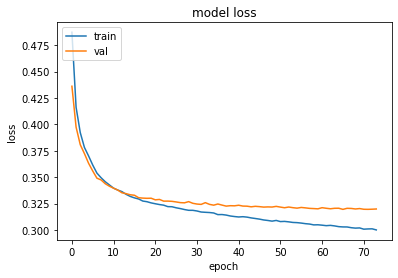

In [ ]:
# Results 
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Val loss:', score[0])
print('Val metrics:', score[1:])

# Show loss history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results on test data

In [ ]:
# Compute test prediction
nb_split = 100

index_split = np.array_split(x_test.index, nb_split)

# To create the file to upload
with open("pred_y.csv", "w") as file:
    file.write("ChallengeID,")
    np.savetxt(file, y_data.columns.to_numpy().reshape(1, len(y_data.columns)), fmt='%s', delimiter=",")

    for i, x_test_split in enumerate(np.array_split(x_test, nb_split)):
        x_test_split = split_in_partition(x_test_split)
        print(f"\tSplit {i+1}/{nb_split}")
        #predictions to add samples
        res = model.predict(x_test_split)
        # if the predictions are > 0.5, then set it to True or False
        res = res > 0.5
        # transform boolean values into binary
        res = res.astype(int)
        res = np.concatenate((index_split[i].to_numpy().reshape(res.shape[0], 1), res), axis=1)

        np.savetxt(file, res, fmt='%d', delimiter=",")